# Необходимы импорты

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
from functools import reduce

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Визуализация 

In [2]:
class PlotData:

    def __init__(self, x, y, weights=[0, 0]):
        """
        weights: array(float), weights = [w_0, w_1]
        model: callable, in this case: f(x) = w_0 + w_1 * x
        """
        self.x = np.array(x)
        self.y = np.array(y)
        self.weights = weights
        self.model = np.vectorize(lambda x: self.weights[0] + self.weights[1] * x)

    def plot_data(self, weights=None):
        
        self.weights = weights if weights else self.weights
        model = self.model(self.x)

        if sum(self.weights) != 0:
            plt.plot(self.x, model, color='indigo', label='f(x)')
        
        plt.scatter(self.x, self.y, color='deeppink', label='data')
        plt.scatter([], [], label=f'weights: w_0 = {self.weights[0]:.2f}; w_1 = {self.weights[1]:.2f}', color='lavender')

        plt.title('Начальное распределение и линия регрессии')

        plt.legend()
        plt.grid(axis='y')
        plt.show()

# Стандартизация

In [3]:
class Normilize:
    def __init__(self, x):
        self.x = np.array(x)

    def fit_transform(self):
        return (self.x - np.mean(self.x, axis=0)) / np.std(self.x, axis=0)

# MSELoss и GradientDescent

## Loss

In [4]:
class MSELoss:

    def __init__(self, weights, x, y):
        """
        weights: array(float), weights = [w_0, w_1]
        model: callable, in this case: f(x) = w_0 + w_1 * x
        """
        self.weights = weights
        self.model = lambda x: self.weights[0] + self.weights[1] * x
        assert len(x) == len(y)
        self.y = y
        self.x = x
        self.dim = (len(y), 1)

    def get_loss(self, method):
        """
        method: one of ('simple', 'func', 'vectorized(returned by default)')
        """
        if method == 'simple':
            return reduce(lambda a, b: a + b, [(self.model(self.x[i]) - self.y[i])**2 for i in range(len(self.x))]) / self.dim[0]
        elif method == 'func':
            return sum([(self.model(self.x[i]) - self.y[i])**2 for i in range(len(self.x))]) / self.dim[0]
        
        return ((np.vectorize(self.model)(np.array(self.x)) - np.array(self.y)) ** 2).mean()
    
    def update_weights(self, weights):
        self.weights = [w for w in weights]

## Мат. часть

<ul>
    <li>$$MSE(f, X, y) = \frac{1}{N}\left\| y - Xw \right\|_{2}^{2}$$</li>
    <li>$$\nabla_{w} MSE(f, X, y) = \frac{2}{N}X^{T}(Xw-y)$$</li>
</ul>
<ul>
<b>Вывод аналитического решения задачи регрессии и $\nabla MSE$:</b><br>
<li>$x^{(1)}, ., ., ., x^{(D)}$ - столбцы матрицы $X$(т.е. столбцы признаки) $\Rightarrow$<br>
$Xw=w_{1}x^(1) + . . . + w_{D}x^{D}$, то есть задачу регрессии можно сформулировать так: найти линейную комбинацию столбцов $x^{(1)}, ., ., ., x^{(D)}$, которая наилучшим способом приближает столбец $y$ по евклидовой норме - то есть найти проекцию вектора $y$ на подпространство, образованное векторами $x^{(1)}, ., ., ., x^{(D)}$.<br>
Разложим $y=y_{||}+y_{\bot }$, где $y_{∥}=Xwy_{∥}​=Xw$ - та самая проекция, а $y_{\bot}$​ - ортогональная составляющая, то есть $y_⊥=y-Xw ⊥ x^{(1)}, ., ., ., x^{(D)}$.<br>
В матричном виде это перепишется так(т.к. скалярное произведение ортогональных векторов - $0$):<br>
$X^{T}(y-Xw)=0$, отсюда $w$ выражается как:
$w = (X^{T}X)^{-1}X^{T}y$</li>
<li>
$\nabla_{x} \left\| Xw - y \right\|_{2}^{2}=\left\langle Xw - y, Xw - y \right\rangle$; воспользуемся формулой дифференциала произведения и симметричностью скалярного произведения($h=\Delta x$):<br>
$$
[D_{w_{0}}\left\langle Xw - y, Xw - y \right\rangle](h) = \left\langle [D_{w_{0}}(Xw - y)](h), Xw - y \right\rangle + \left\langle Xw - y, [D_{w_{0}}(Xw - y)](h) \right\rangle = 2\left\langle Xw - y, [D_{w_{0}}(Xw - y)](h) \right\rangle=2\left\langle (Xw_{0} - y), Xh \right\rangle=\left\langle 2X^{T}(Xw_{0} - y), h \right\rangle
$$
Получим, что:
$\nabla_{w_{0}}MSE=\frac{2}{N}X^{T}(Xw_0-y)$
</li>
</ul>

$lim_{\Delta x -> 0}=\frac{f(x+\Delta x) - f(x)}{\Delta x} + o(x)$

Про ортогональную проекцию о иртогональную состовляющую:<br>
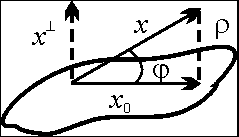<br>
<ul>
    <li>$x^{\bot}$ - ортогональная состовляющая $\bar{x}$</li>
    <li>$\phi$ - проекция $\bar{x}$</li>
</ul>

## Gradient Descent

In [5]:
class Optimizer:
    
    def __init__(self, x, y, learning_rate=0.01):
        """
        weights: array(float), weights = [w_0, w_1]
        model: callable, in this case: f(x) = w_0 + w_1 * x
        """
        self.weights = [1, 1]
        self.model = lambda x: self.weights[0] + self.weights[1] * x
        self.learning_rate = learning_rate
        assert len(x) == len(y)
        self.y = y
        self.x = x
        self.dim = (len(y), 1)

    def step(self, method='vectorized'):
        """
        method: one of ('simple', 'func', 'vectorized(returned by default)')
        """
        if method == 'simple':
                grad =  [
                        2 * reduce(lambda a, b: a + b, [(self.model(self.x[i]) - self.y[i]) for i in range(len(self.x))]) / self.dim[0],
                        2 * reduce(lambda a, b: a + b, [(self.model(self.x[i]) - self.y[i]) * self.x[i] for i in range(len(self.x))]) / self.dim[0]
                    ]
        elif method == 'func':
            grad = [
                        2 * sum([(self.model(self.x[i]) - self.y[i]) for i in range(len(self.x))]) / self.dim[0],
                        2 * sum([(self.model(self.x[i]) - self.y[i]) * self.x[i] for i in range(len(self.x))]) / self.dim[0]
                    ]
        else:
            # col with ones for intercept
            x_vec = np.column_stack([np.ones(self.dim[0]), self.x])
            error = x_vec @ np.array(self.weights) - np.array(self.y)
            grad = 2 * x_vec.T @ error / self.dim[0]

        self.weights = [self.weights[i] - self.learning_rate * grad[i] for i in range(len(grad))]

        return self.weights

# Predictor

In [6]:
class Predictor:

    def __init__(self, weights=[1, 1]):
        
        self.weights = weights

    def predict(self, x, weights=None):

        self.weights = weights if weights else self.weights

        return self.weights[0] + self.weights[1] * x

# Tools

In [7]:
def read_data(filename):

    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        data = [list(map(float, row.strip().split(','))) for row in f.readlines()]
    
    return data

def save_weights(filename, weights):
    
    with open(os.path.join(os.getcwd(), filename), 'wb') as f:
        pickle.dump(weights, f)

def load_model(filename):
    weights = pickle.load(open(os.path.join(os.getcwd(), filename), 'rb'))
    return weights

def train(x, y, iterations=100, learning_rate=0.01, verbose=False, method='simple'):

    opt = Optimizer(x, y, learning_rate)
    loss = MSELoss([0, 0], x, y)

    for iter in range(1, iterations + 1):
        
        weights = opt.step(method)
        loss.update_weights(weights)

        if verbose:
            print(f'Loss на {iter} итерации: ', loss.get_loss(method))
    
    return weights, loss.get_loss(method)

def find_best_model(x, y, grid=None, method='simple'):
    
    grid = grid if grid else {'iterations': np.arange(1, 250, 10), 'leanrning_rate': [0.001, 0.003, 0.01, 0.5, 0.9]}
    best_loss = float('inf')
    best_pair = [None, None]
    bets_weights = [None, None]

    p_1, p_2 = grid.keys()
    
    for iter in grid[p_1]:
        for lr in grid[p_2]:
            weights, loss = train(x, y, iterations=iter, learning_rate=lr, method=method)
            if loss < best_loss:
                best_loss, best_pair, bets_weights = loss, (iter, lr), weights
    
    return bets_weights, best_loss, best_pair

# Main

In [8]:
def main(plot=False):

    data = np.array(read_data('ex1data1.txt'))
    x, y = data[:, 0], data[:, 1]
    weights = [0, 0]

    if plot:
        plotter = PlotData(x, y)
        plotter.plot_data()

    method = 'simple' # 'simple', 'func', 'vectorized'
    loss = MSELoss(weights, x, y)

    if plot: print('Стартовый loss: ', loss.get_loss(method))
    
    param_grid = {'iterations': [250], 'leanrning_rate': [0.001, 0.003, 0.01, 0.5, 0.9]}

    best_weights, best_loss, best_pair = find_best_model(x, y, grid=param_grid, method=method)

    if plot: print('Лучший loss: ', best_loss)
    if plot: plotter.plot_data(best_weights)

    save_weights('weights.pkl', best_weights)

# Решение градиеными методами

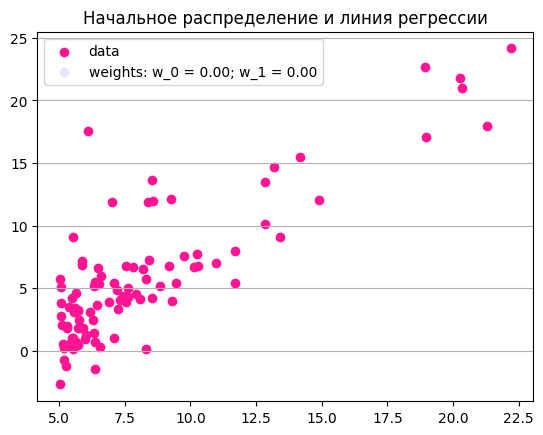

Стартовый loss:  64.14546775491131
Лучший loss:  9.662447756103345


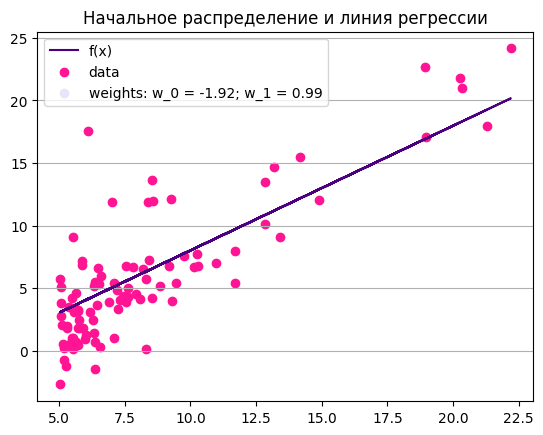

In [9]:
main(True)

# Предсказание цены

In [10]:
weights = load_model('weights.pkl')
pred_grad = Predictor(weights=weights)

# Шапка таблицы
header = f"\n{'Градиент':>12}"
separator = "-" * 50

print("Ожидаемая прибыль:")

while True:
    x_1 = int(input('Введите число пунктов: '))
    
    # Получаем предсказания
    grad = pred_grad.predict(x_1)
    
    # Форматируем вывод
    print(header)
    print(separator)
    print(f"{grad:>12.2f}")
    
    out = int(input('\nВыйти?(0, 1) - '))
    if out == 1: 
        break

Ожидаемая прибыль:


Введите число пунктов:  23



    Градиент
--------------------------------------------------
       20.96



Выйти?(0, 1) -  1
